<a href="https://colab.research.google.com/github/sadiareem/icece_LCC/blob/main/96_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from collections import defaultdict
import pandas as pd
import PIL
from pathlib import Path

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Paths
dataset_path = '/content/drive/MyDrive/Datasets/lungCT'
data_dir = Path(dataset_path)

Mounted at /content/drive


In [ ]:
from collections import defaultdict
import pandas as pd
import PIL
from pathlib import Path
# Function to count images in each class
def count_images(data_dir):
    class_counts = defaultdict(int)
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            num_images = len(list(class_dir.glob('*')))
            class_counts[class_name] = num_images
    return class_counts

# Function to extract image information
def get_image_info(data_dir):
    image_info = []
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob('*'):
                img = PIL.Image.open(img_path)
                image_info.append({
                    "Filename": img_path.name,
                    "Class": class_dir.name,
                    "Format": img.format,
                    "Size": img.size,
                    "Mode": img.mode
                })
    return pd.DataFrame(image_info)

# Function to summarize image dimensions
def summarize_image_info(image_info_df):
    print("\nImage Dimension Statistics:")
    print(f"Min width: {image_info_df['Size'].apply(lambda x: x[0]).min()}")
    print(f"Max width: {image_info_df['Size'].apply(lambda x: x[0]).max()}")
    print(f"Min height: {image_info_df['Size'].apply(lambda x: x[1]).min()}")
    print(f"Max height: {image_info_df['Size'].apply(lambda x: x[1]).max()}")
    print(f"Average width: {image_info_df['Size'].apply(lambda x: x[0]).mean()}")
    print(f"Average height: {image_info_df['Size'].apply(lambda x: x[1]).mean()}")

# Function to visualize sample images from each class
def visualize_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_dir = data_dir / class_name
        sample_images = list(class_dir.glob('*'))[:num_samples]
        for j, img_path in enumerate(sample_images):
            img = PIL.Image.open(img_path)
            ax = plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to check for corrupted images
def check_for_corrupted_images(data_dir):
    corrupted_images = []
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob('*'):
                try:
                    img = PIL.Image.open(img_path)
                    img.verify()  # Verify if the image can be opened
                except (IOError, SyntaxError) as e:
                    corrupted_images.append(img_path)
    return corrupted_images

# Function to generate a summary report
def generate_summary_report(data_dir, class_counts, image_info_df):
    print("\nDataset Summary Report")
    print("=" * 30)
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Total number of images: {sum(class_counts.values())}")
    print("\nImages per class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    summarize_image_info(image_info_df)

    corrupted_images = check_for_corrupted_images(data_dir)
    if corrupted_images:
        print("\nCorrupted images detected:")
        for img_path in corrupted_images:
            print(f"- {img_path}")
    else:
        print("\nNo corrupted images detected.")

# Extract and display dataset information
class_counts = count_images(data_dir)
image_info_df = get_image_info(data_dir)
generate_summary_report(data_dir, class_counts, image_info_df)



Dataset Summary Report
Total number of classes: 4
Total number of images: 1000

Images per class:
adenocarcinoma: 338 images
squamouscellcarcinoma: 260 images
largecellcarcinoma: 187 images
normal: 215 images

Image Dimension Statistics:
Min width: 168
Max width: 1200
Min height: 110
Max height: 874
Average width: 431.383
Average height: 323.639

No corrupted images detected.


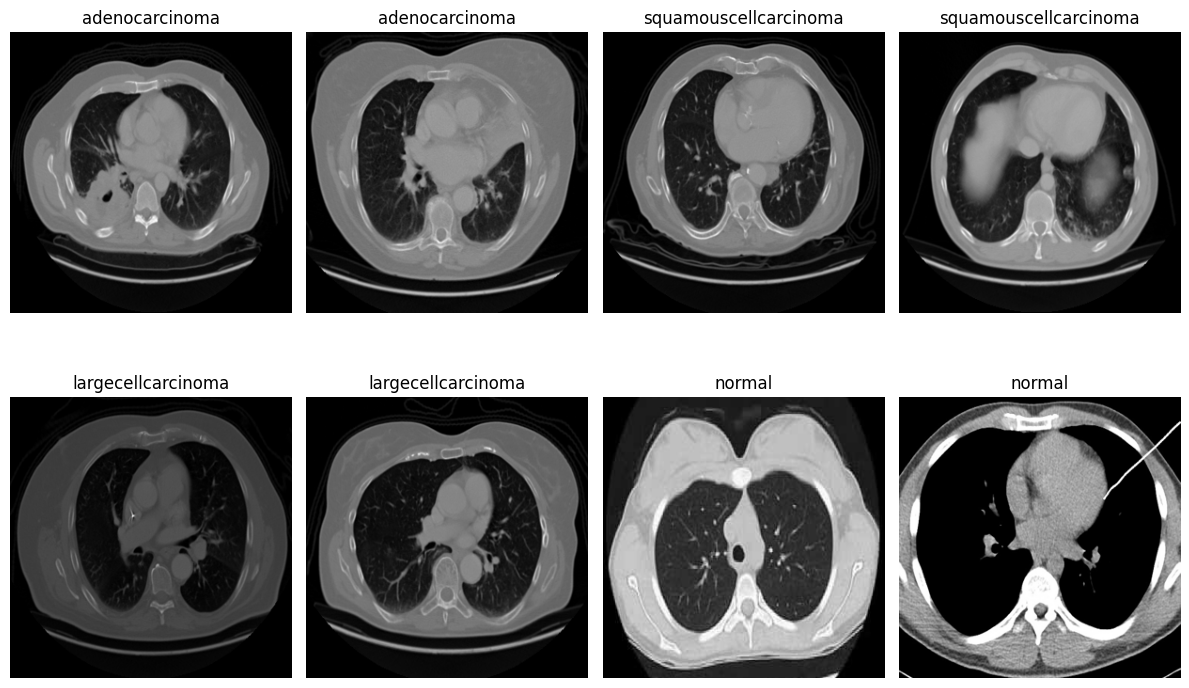

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import PIL
from PIL import Image

def visualize_images_from_each_class(data_dir, num_classes=4, num_samples_per_class=2, img_size=(300, 300)):
    # Get list of class directories
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    class_names = [d.name for d in class_dirs]

    plt.figure(figsize=(12, 8))

    for i, class_name in enumerate(class_names):
        class_dir = data_dir / class_name
        sample_images = list(class_dir.glob('*'))[:num_samples_per_class]

        for j, img_path in enumerate(sample_images):
            img = PIL.Image.open(img_path).resize(img_size)  # Resize image
            ax = plt.subplot(num_classes // 2, num_samples_per_class * 2, i * num_samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize images
visualize_images_from_each_class(data_dir)


In [ ]:
# Image Data Generators for loading and augmenting data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2  # Using 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 801 images belonging to 4 classes.
Found 199 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

# Define input shape
input_shape = (180, 180, 3)

# Load the EfficientNetB7 base model with pre-trained weights
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the first half of the layers
num_layers = len(base_model.layers)
for layer in base_model.layers[:num_layers // 2]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 180, 180, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 180, 180, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 181, 181, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 90, 90, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 90, 90, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 90, 90, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 90, 90, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 90, 90, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 90, 90, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,426,523 (245.77 MB)

 Trainable params: 59,565,532 (227.22 MB)

 Non-trainable params: 4,860,991 (18.54 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 915s 31s/step - accuracy: 0.4092 - loss: 1.5132 - val_accuracy: 0.4673 - val_loss: 1.2479
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 789s 30s/step - accuracy: 0.5850 - loss: 1.0140 - val_accuracy: 0.5075 - val_loss: 1.1172
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 781s 30s/step - accuracy: 0.6716 - loss: 0.8277 - val_accuracy: 0.5678 - val_loss: 1.0035
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 774s 30s/step - accuracy: 0.7704 - loss: 0.5798 - val_accuracy: 0.6231 - val_loss: 0.9169
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 803s 30s/step - accuracy: 0.7834 - loss: 0.4970 - val_accuracy: 0.7136 - val_loss: 0.7427
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 816s 30s/step - accuracy: 0.8214 - loss: 0.4505 - val_accuracy: 0.7839 - val_loss: 0.5935
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 784s 30s/step - accuracy: 0.8626 - loss: 0.3640 - val_accuracy: 0.8342 - val_loss: 0.4984
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 785s 30s/step - accuracy: 0.8621 - loss: 0.3494 - val_accuracy: 0.8593 - val_

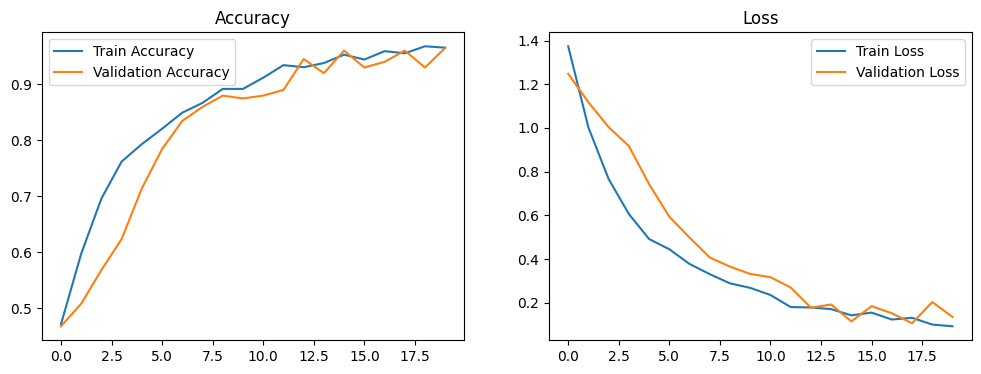

In [ ]:
# Plot Accuracy and Loss graphs
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 94s 12s/step


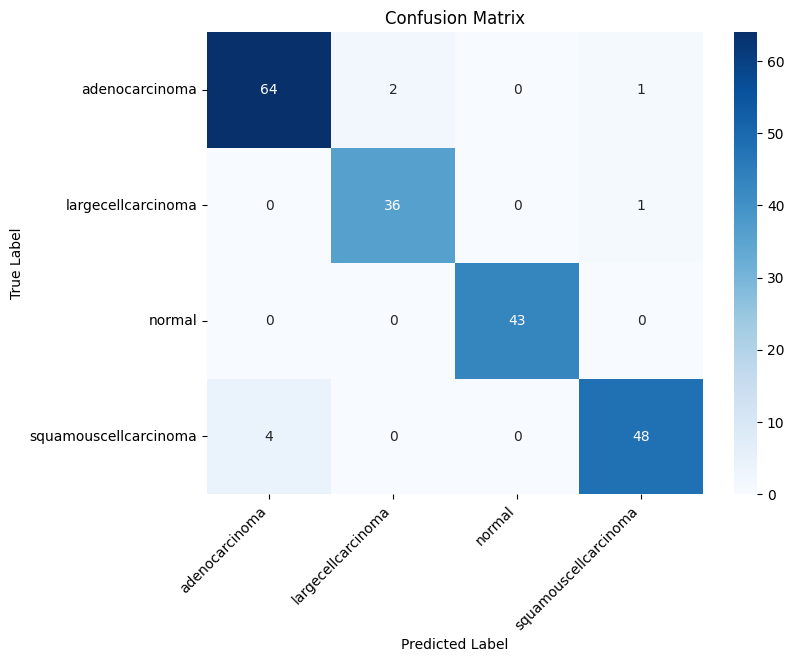

                       precision    recall  f1-score   support

       adenocarcinoma       0.94      0.96      0.95        67
   largecellcarcinoma       0.95      0.97      0.96        37
               normal       1.00      1.00      1.00        43
squamouscellcarcinoma       0.96      0.92      0.94        52

             accuracy                           0.96       199
            macro avg       0.96      0.96      0.96       199
         weighted avg       0.96      0.96      0.96       199



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

steps = validation_generator.samples // validation_generator.batch_size
y_pred_probs = model.predict(validation_generator, steps=steps + 1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix using class predictions, not probabilities
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Rotate labels on the x-axis
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [ ]:
# Example class names (replace or modify this list according to your specific classes)
class_names = ['adenocarcinoma', 'largecellcarcinoma', 'normal', 'squamouscellcarcinoma']

# Function to calculate TP, FP, TN, FN for each class using class names
def get_performance_metrics(conf_matrix, class_names):
    performance_dict = {}
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (FP + FN + TP)
        performance_dict[class_names[i]] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}
    return performance_dict

# Get the metrics for each class
metrics = get_performance_metrics(conf_matrix, class_names)

# Print the results for each class using class names
for class_name, values in metrics.items():
    print(f"{class_name}:")
    for metric, value in values.items():
        print(f"  {metric}: {value}")
    print()  # Adding a newline for better readability


adenocarcinoma:
  TP: 64
  FP: 4
  TN: 128
  FN: 3

largecellcarcinoma:
  TP: 36
  FP: 2
  TN: 160
  FN: 1

normal:
  TP: 43
  FP: 0
  TN: 156
  FN: 0

squamouscellcarcinoma:
  TP: 48
  FP: 2
  TN: 145
  FN: 4



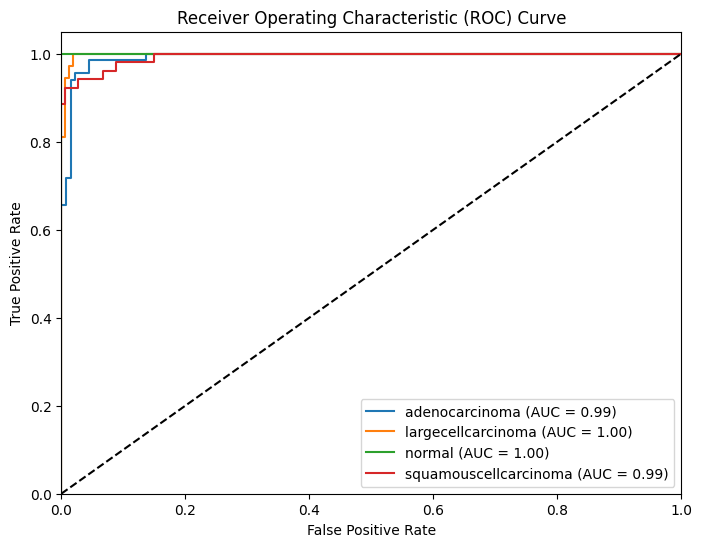

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize dictionaries for storing FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Define class labels
class_labels = ['adenocarcinoma', 'largecellcarcinoma', 'normal', 'squamouscellcarcinoma']

# Compute ROC curve and ROC area for each class
for i in range(4):  # Assuming 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])  # Use probabilities, not class labels
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 93s 13s/step


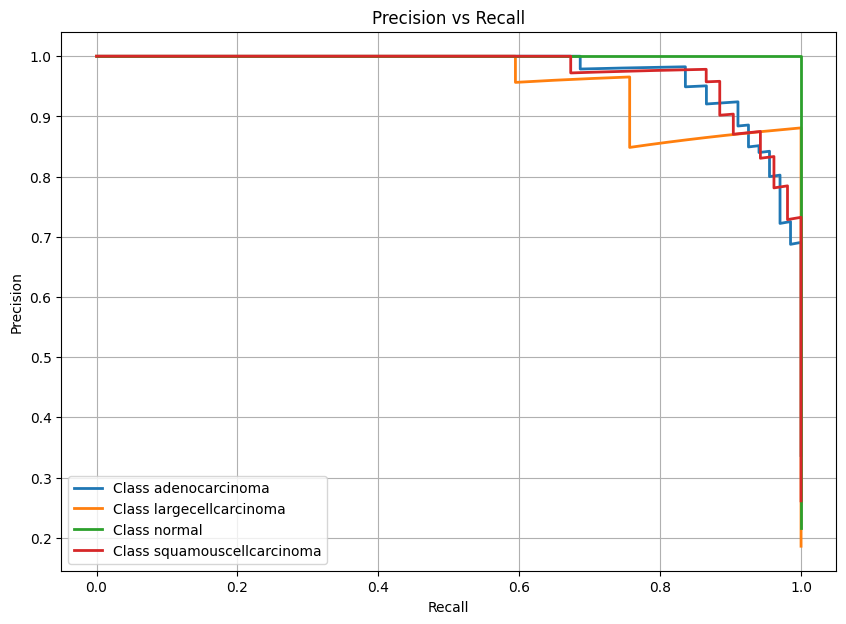

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Get the true labels from the validation generator
val_true_classes = validation_generator.classes  # This gets the true labels

# Get the predicted probabilities from the model
val_preds = model.predict(validation_generator)  # Predicted probabilities

# Initialize dictionaries for precision and recall
precision = {}
recall = {}

# Compute precision-recall curve for each class
for i in range(len(validation_generator.class_indices)):  # Iterate over each class
    precision[i], recall[i], _ = precision_recall_curve(val_true_classes == i, val_preds[:, i])  # Use predicted probabilities

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(10, 7))

for i, class_name in enumerate(validation_generator.class_indices.keys()):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {class_name}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend(loc="best")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


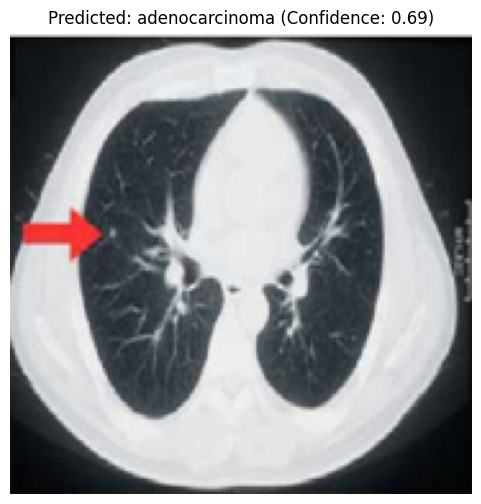

Predicted class: adenocarcinoma, Confidence: 0.69


In [ ]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Define constants (same as the input size used in the model)
img_height, img_width = 180, 180  # Resize dimensions for ResNet50V2

# Define the function to predict the class of a new image
def predict_image(image_path):
    try:
        # Load and preprocess the image
        image = PIL.Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
        image = image.resize((img_height, img_width))
        image_array = np.array(image) / 255.0  # Normalize the image (ResNet50V2 expects normalized input)

        # Check the number of dimensions and channels of the image
        if image_array.ndim == 3 and image_array.shape[2] == 3:
            image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        else:
            raise ValueError("Image must be RGB with 3 channels")

        # Model prediction
        prediction = model.predict(image_array)

        # Get the predicted class and confidence
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction)

        # Display the image and prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
        plt.show()

        return predicted_class, confidence

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, None

# Example path to a new image
new_image_path = '/content/drive/My Drive/Datasets/testing/predict.jpg'
predicted_class, confidence = predict_image(new_image_path)

if predicted_class is not None and confidence is not None:
    print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")
else:
    print("Prediction could not be made.")
